### Imports and setup

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from utils import get_json_from_text, prompt_model

### Acknowledgement

Task of structuring bibliographical entries from Benjamin Franklin's library adapted from the excellent [marginalia project](https://github.com/Pleias/marginalia/tree/main)'s example notebooks.

![Drag Racing](franklin_first_page.png)

In [2]:
df = pd.read_csv("franklin_library.csv")
df.head()

,text
0,"FINE large Folio BIBLE, compleat, Oxford 1727."
1,"Ditto, with Maps, Notes, &c."
2,"Clarendon's History of the Rebellion, 3 Vols"
3,Bayley's universal etimologlcal Dictionary.
4,Marlorati Thesaurus Scripturae.


## Zero-shot prompting

In [3]:
prompt = """
Transform a book entry into structured bibliographic data.

Extract the following bibliographic fields:
- the author(s) of the book, which can be expressed with a possessive like Hobbes's ("author")
- the title of the book ("title")
- the translator(s) of the book ("translator")
- the date of publication ("date")
- the place of publication ("place")
- any information related to the format such as volumes, folios ("format") 
- any other information related to the book ("other")

Return the results as a valid JSON object structured like this:
{"author": "…", "title": "…", "translator": "…", "date": "…", "place": "…", "format": "…", "other": "…"}

The book entry:
```
FINE large Folio BIBLE, compleat, Oxford 1727.
```
"""


print(prompt_model(prompt))

Here is the extracted bibliographic data in a JSON object:

```
{
  "author": "unknown (Bible)",
  "title": "large Folio BIBLE",
  "date": "1727",
  "place": "Oxford",
  "format": "Folio",
  "other": "compleat"
}
```

Note: Since the author is not explicitly specified, I've annotated it as "unknown (Bible)" to reflect that it's a Bible publication, but the actual author is not provided.


## Few-shot prompting

In [4]:
good_answer = """
Here is the extracted bibliographic data in JSON format:

```
{
  "author": null,
  "title": "BIBLE",
  "translator": null,
  "date": "1727",
  "place": "Oxford",
  "format": "Folio",
  "other": "compleat"
}
```
"""

rebellion_question = """
Another book entry:
```
Clarendon's History of the Rebellion, 3 Vol
```
"""

history = [
    (prompt, good_answer),
]

print(prompt_model(rebellion_question, history))

Here is the extracted bibliographic data in JSON format:

```
{
  "author": "Clarendon's",
  "title": "History of the Rebellion",
  "translator": null,
  "date": null,
  "place": null,
  "format": "3 Vol",
  "other": null
}
```


🧑‍💻 **Exercise** Use *History of the Rebellion* as a few-shot example as well by defining the `rebellion_answer` variable in the cell below. Then try to analyze book entry `Wiquefort's compleat Ambassador, translated by Digby, finely bound.` by defining `ambassador_question`.

In [ ]:
rebellion_answer = """
<your answer here>
"""

ambassador_question = """
<your question regarding "Wiquefort's compleat Ambassador, translated by Digby, finely bound." here>
"""

history = [(prompt, good_answer), (rebellion_question, rebellion_answer)]

print(prompt_model(ambassador_question, history))

🧑‍💻 **Exercise** Add a final example by defining `ambassador_answer` in the cell below. Test your prompt on the entry `Hobbes's Leviathan, very scarce.` by defining `new_question`.

In [ ]:
ambassador_answer = """
<your answer regarding "Wiquefort's compleat Ambassador, translated by Digby, finely bound." here>
"""

new_question = """
<your question regarding "Hobbes's Leviathan, very scarce." here>
"""

history = [
    (prompt, good_answer),
    (rebellion_question, rebellion_answer),
    (ambassador_question, ambassador_answer),
]

print(prompt_model(new_question, history))

### Scaling up

In [7]:
new_question_template = """
Another book entry:
```
{entry}
```
"""

print(new_question_template.format(entry="Hobbes's Leviathan, very scarce."))


Another book entry:
```
Hobbes's Leviathan, very scarce.
```



🧑‍💻 **Action needed** Make sure that the *History of the Rebellion* and *Ambassador* questions and answers are used as additional examples in the call below by adding them as (question, answer) pairs to the chat history. You can simply remove the `# ` in front of each pair.

Running this cell might take a while. You can change the value of `n_entries` to only process the first `n_entries` entries.

In [8]:
entries = df["text"].tolist()

history = [
    (prompt, good_answer),    
    # (rebellion_question, rebellion_answer),
    # (ambassador_question, ambassador_answer),
]

responses = []
n_entries = None # set to an integer (50, 100, ..) to restrict the number of entries processed

for entry in tqdm(entries[:n_entries]):
    new_question_formatted = new_question_template.format(entry=entry)
    response = prompt_model(new_question_formatted, history)
    responses.append(response)

100%|█████████████████████████████████████████| 445/445 [07:42<00:00,  1.04s/it]


In [9]:
print(responses[10])

Here is the extracted bibliographic data in JSON format:

```
{
  "author": "Sturmii",
  "title": "Mathesis Compendiaria",
  "translator": null,
  "date": null,
  "place": null,
  "format": null,
  "other": null
}
```


In [10]:
get_json_from_text(responses[10])

{'author': 'Sturmii',
 'title': 'Mathesis Compendiaria',
 'translator': None,
 'date': None,
 'place': None,
 'format': None,
 'other': None}

In [11]:
json_objects = [get_json_from_text(response) for response in responses]

In [12]:
df_structured = pd.DataFrame(json_objects)

In [13]:
df_structured.head()

,author,title,translator,date,place,format,other
0,None,BIBLE,None,1727,Oxford,Folio,compleat
1,None,None,None,None,None,None,"with Maps, Notes, &c."
2,Clarendon's,History of the Rebellion,None,None,None,3 Vols,None
3,Bayley's,universal etimologlcal Dictionary,None,None,None,None,None
4,Marlorati,Thesaurus Scripturae,None,None,None,None,None


In [18]:
df_structured.to_csv("franklin_structured.csv")

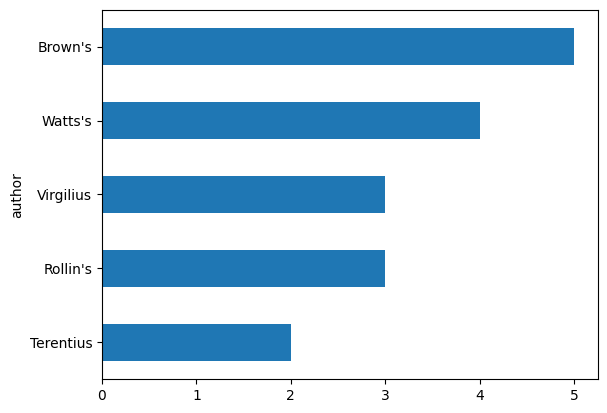

In [17]:
# look at Benjamin Franklin's top 5 authors
fig, ax = plt.subplots()
df_structured["author"].value_counts().iloc[:5].plot(kind="barh", ax=ax);
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.invert_yaxis()

plt.savefig("barplot.png")